In [3]:
pip install langdetect


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata
import tensorflow as tf


%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [6]:
df1=pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')
df1.head(2)

/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/2018006824.py:1: DtypeWarning: Columns (1,3,6,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df1=pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at\r
0,15/10/2020 00:00,1.32E+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0,0.0,TweetDeck,360666534,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,21/10/2020 00:00\r
1,15/10/2020 00:00,1.32E+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26,9.0,Social Mediaset,331617619,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00.4\r


In [8]:
df2=pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')
df2.head(2)

/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/2304426348.py:1: DtypeWarning: Columns (3,6,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at\r
0,15/10/2020,1.316530e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.00,0.0,TweetDeck,360666534.00,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,21/10/2020\r
1,15/10/2020,1.316530e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.00,0.0,Twitter for iPad,809904438.00,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21/10/2020\r


In [14]:
tweets_biden = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

# Replace United states in country column with USA full form
tweets_biden['country'].replace({'United States':'United States of America'}, inplace=True)
tweets_trump['country'].replace({'United States':'United States of America'}, inplace=True)


# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
tweets_biden['user_join_date'] = pd.to_datetime(tweets_biden['user_join_date'], errors='coerce')
tweets_trump['user_join_date'] = pd.to_datetime(tweets_trump['user_join_date'], errors='coerce')
tweets_biden['collected_at\r'] = pd.to_datetime(tweets_biden['collected_at\r'], errors='coerce')
tweets_trump['collected_at\r'] = pd.to_datetime(tweets_trump['collected_at\r'], errors='coerce')
tweets_biden['created_at'] = pd.to_datetime(tweets_biden['created_at'], errors='coerce')
tweets_trump['created_at'] = pd.to_datetime(tweets_trump['created_at'], errors='coerce')
# create additional date time columns
tweets_biden['created_at_r']=tweets_biden['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r']=tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden['created_at_r2']=tweets_biden['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2']=tweets_trump['created_at'].dt.strftime('%m-%d')
tweets_biden['likes'] = pd.to_numeric(tweets_biden['likes'], errors='coerce').fillna(0)
tweets_biden['retweet_count'] = pd.to_numeric(tweets_biden['retweet_count'], errors='coerce').fillna(0)
tweets_trump['likes'] = pd.to_numeric(tweets_trump['likes'], errors='coerce').fillna(0)
tweets_trump['retweet_count'] = pd.to_numeric(tweets_trump['retweet_count'], errors='coerce').fillna(0)
def normalise(x, y):
    x = np.array(x)
    y = np.array(y)
    # Avoid division by zero and handle NaN values
    return np.where(y == 0, 0, x / y)

# normalise time diff to hours
b_tdiff=(tweets_biden['collected_at\r'] - tweets_biden['created_at'])
t_tdiff=(tweets_trump['collected_at\r'] - tweets_trump['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden['likes_norm'] = normalise(tweets_biden['likes'],b_tdiff)
tweets_biden['retweet_norm'] = normalise(tweets_biden['retweet_count'],b_tdiff)
tweets_trump['likes_norm'] = normalise(tweets_trump['likes'],t_tdiff)
tweets_trump['retweet_norm'] = normalise(tweets_trump['retweet_count'],t_tdiff)

tweets_biden.tail(2)

/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/573302903.py:1: DtypeWarning: Columns (3,6,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_biden = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/573302903.py:2: DtypeWarning: Columns (1,3,6,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_trump = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)
/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/573302903.py:27: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  tweets_biden['created_at'] = pd.to_datetime(tweets_biden['created_at'], errors='coerce')
/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,city,country,continent,state,state_code,collected_at\r,created_at_r,created_at_r2,likes_norm,retweet_norm
499957,2020-05-11,1.324500e+18,I wonder who they’re voting for 🤔... - #fyp #f...,0.0,0.0,Instagram,831707520007708032.0,NathanKTV,NathanKTV_,💁🏻‍♂️: IG 👉 NathanKTV \n🎥: 👇🏼\nhttps://t.co/o...,...,NaN,United States of America,North America,California,CA,2020-06-11,2020-05-11 00,05-11,0.0,0.0
499958,2020-05-11,1.324500e+18,Biden - 290 \nTrump 🤡 - 248 \nEasy money babby...,0.0,0.0,Twitter for iPhone,907107470874512896.0,BraddahBit 🤙🏽,alohacory_,crypto degenerate : truth seeker : datsun enth...,...,San Francisco,United States of America,North America,California,CA,2020-06-11,2020-05-11 00,05-11,0.0,0.0


In [15]:
# Visualisation functions
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/275198889.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)


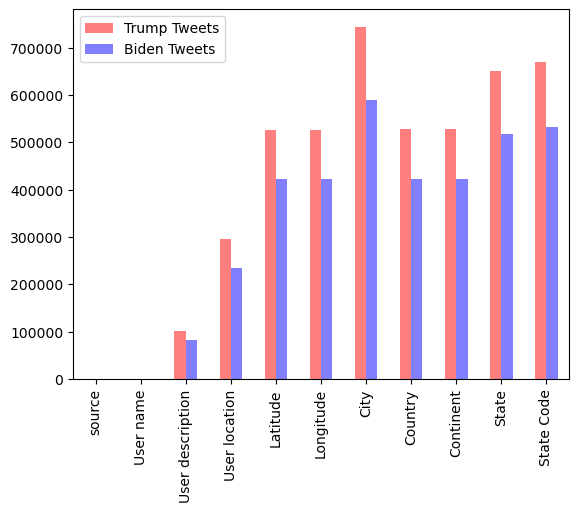

In [16]:
df = pd.DataFrame({
    'States': ['source', 'User name', 'User description', 'User location','Latitude','Longitude','City','Country','Continent','State','State Code'],
    'Trump Tweets': [876, 16, 101266, 294953, 525200, 525200, 743732, 528171, 528154, 650299, 670494],
    'Biden Tweets': [713, 18, 82006, 233791, 421593, 421593, 590014, 423107, 423089, 516691, 532277]
})

colours = ['r', 'b'][0:len(df.columns)]
ax =df.plot(x="States", y=["Trump Tweets", "Biden Tweets"], kind="bar",color=colours,alpha=0.5)
# df.plot(figsize=(6,3))
ax.set_xlabel("")
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams.update({'font.size': 15})

[194, 67, 67, 942, 187, 200, 185, 74361, 321, 196, 220694, 383788, 383786, 553422, 385982, 385969, 477762, 492461, 452742, 194, 194, 452742, 452742]


) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


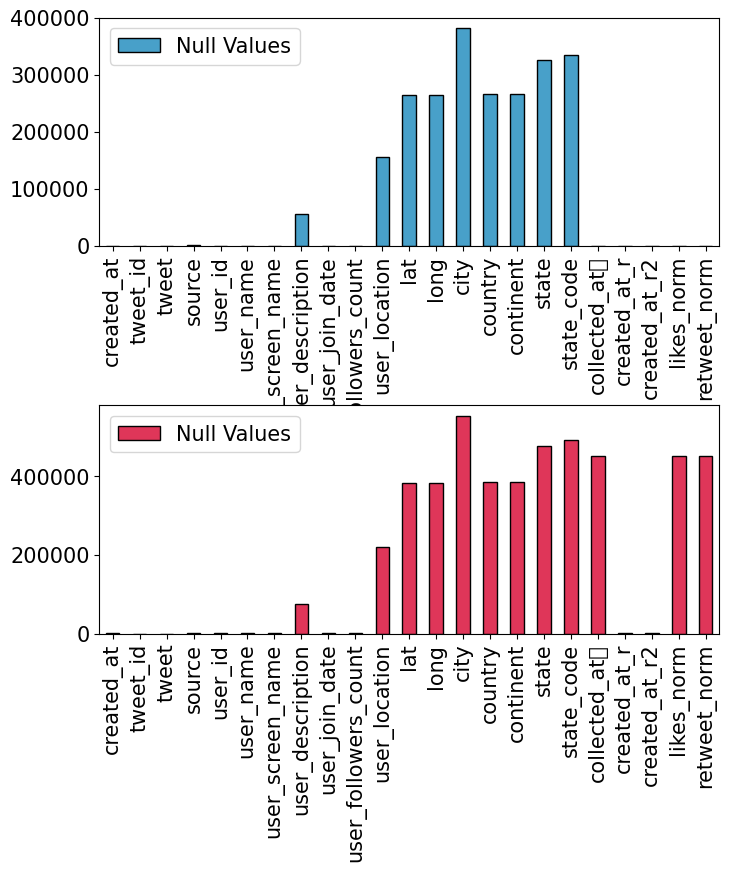

<Figure size 2000x500 with 0 Axes>

In [17]:
na_vals_b=pd.DataFrame({'Null Values':tweets_biden.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]
print(na_vals_t["Null Values"].tolist())

performance = [[na_vals_b,na_vals_t]]
# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(8,8), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
# ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
# ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()


fig1 = plt.figure()

In [18]:
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

In [19]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaishreeram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jaishreeram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']
def clean1(sent):
    filtered_sent=""
    stopwords = nltk.corpus.stopwords.words('english')
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',sent)
    words=sent.split()
    for word in words:
        if word not in stopwords:
            filtered_sent=filtered_sent+' '+word
    return filtered_sent

def clean2(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', ' ', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words1 = clean2(''.join(str(text1.apply(clean1).tolist())))
words2 = clean2(''.join(str(text2.apply(clean1).tolist())))
words1[:10]

['islandgirlprv',
 'bradbeauregardj',
 'meidastouch',
 'ccp',
 'thats',
 'always',
 'fine',
 'jack',
 'vijaya',
 'dickc']

In [21]:
trump_df_init = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')
biden_df_init = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')

/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/2095087823.py:1: DtypeWarning: Columns (3,6,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  trump_df_init = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')
/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/2095087823.py:2: DtypeWarning: Columns (1,3,6,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  biden_df_init = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')


In [43]:
print(biden_df.index)

Int64Index([     0,      2,      4,      5,      7,      8,     11,     12,
                19,     22,
            ...
            725777, 725782, 725787, 725802, 725808, 725817, 725821, 725824,
            725838, 725840],
           dtype='int64', length=147395)


In [44]:
biden_df = biden_df_init[biden_df_init['country'] == 'United States of America'].copy()
trump_df = trump_df_init[trump_df_init['country'] == 'United States of America'].copy()
biden_df.loc[725840]["tweet"]

'Biden - 290 \nTrump 🤡 - 248 \nEasy money babbyyyyyyy!! #maga #trump #biden #biden2020'

In [45]:
biden_df.loc[:,'who'] = 'biden'
trump_df.loc[:,'who'] = 'trump'
data = pd.concat([biden_df, trump_df])

In [46]:
def _calculate_languages_ratios(text):
    languages_ratios = {}

    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]

    # Compute per language included in nltk number of unique stopwords appearing in analyzed text
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)

        languages_ratios[language] = len(common_elements) # language "score"

    return languages_ratios

def detect_language(text):
    ratios = _calculate_languages_ratios(text)

    most_rated_language = max(ratios, key=ratios.get)

    return most_rated_language

In [47]:
import sys, os
import re
from tqdm.auto import tqdm
from nltk import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaishreeram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
def filter_english_one_to_one(df, who):
    tweets = df.query(f'who == "{who}" and state_code == state_code')
    tweets['user_followers_count'] = pd.to_numeric(tweets['user_followers_count'], errors='coerce')  # Convert to numeric, replacing non-numeric values with NaN
    tweets = tweets.sort_values('user_followers_count', ascending=False).drop_duplicates(['user_name'])[['tweet', 'long', 'lat', 'state_code']]
    languages = [detect_language(val) for val in tqdm(tweets.tweet)]
    filtered = tweets.loc[np.array(languages) == 'english']
    return filtered
def filter_english_sample_100(df, who):
    tweets = df.query(f'who == "{who}" and state_code == state_code').sort_values('user_followers_count',ascending=False)[['user_id','tweet','long','lat','state_code']]
    tweets = tweets.groupby("user_id").apply(
        lambda group_df: group_df.sample(100) if len(group_df) > 100 else group_df
    ).reset_index(drop=True)
    languages = [detect_language(val) for val in tqdm(tweets.tweet)]
    filtered = tweets.loc[np.array(languages) == 'english']
    return filtered

In [49]:
filt_biden_df = filter_english_one_to_one(data, 'biden')

/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/1125556418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['user_followers_count'] = pd.to_numeric(tweets['user_followers_count'], errors='coerce')  # Convert to numeric, replacing non-numeric values with NaN


  0%|          | 0/33477 [00:00<?, ?it/s]

In [50]:
filt_trump_df = filter_english_one_to_one(data, 'trump')

/var/folders/yc/drdkfqm540l_z3lpnprppnt80000gn/T/ipykernel_51505/1125556418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['user_followers_count'] = pd.to_numeric(tweets['user_followers_count'], errors='coerce')  # Convert to numeric, replacing non-numeric values with NaN


  0%|          | 0/36345 [00:00<?, ?it/s]

In [51]:
def tweet_clean_up(df):
    remove_links = lambda txt: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', txt)
    remove_special = lambda txt: re.sub(r'[^a-zA-Z0-9!,.\'\"\?\-\s]', '', txt)
    remove_newline = lambda txt: re.sub(r'\n', ' ', txt)
    df['tweet'] = df['tweet'].apply(lambda x: remove_newline(remove_special(remove_links(x))))
    return df

In [54]:
def tweet_clean_up2(x):
    remove_links = lambda txt: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', txt)
    remove_special = lambda txt: re.sub(r'[^a-zA-Z0-9!,.\'\"\?\-\s]', '', txt)
    remove_newline = lambda txt: re.sub(r'\n', ' ', txt)
    
    return remove_newline(remove_special(remove_links(x)))

In [55]:
tweet_clean_up2("Biden - 290 \nTrump 🤡 - 248 \nEasy money babbyyyyyyy!! #maga #trump #biden #biden2020")

'Biden - 290  Trump  - 248  Easy money babbyyyyyyy!! maga trump biden biden2020'

In [56]:
cleaned_biden = tweet_clean_up(filt_biden_df)
cleaned_trump = tweet_clean_up(filt_trump_df)

In [57]:
cleaned_biden.loc[:,'sentiment'] = 0
cleaned_trump.loc[:,'sentiment'] = 0

In [58]:
cleaned_biden.to_csv('cleaned_sample_100_biden.csv', index=False, header=True)
cleaned_trump.to_csv('cleaned_sample_100_trump.csv', index=False, header=True)

In [60]:
print(cleaned_trump.index)

Int64Index([465323, 337282, 109523, 286861, 384381, 495250, 103692,  59019,
            230817, 466163,
            ...
             67752, 373130, 332877, 410273,  95270, 126406, 166107, 332110,
            189520, 119343],
           dtype='int64', length=11244)


In [61]:
cleaned_trump.loc[119343]["tweet"]

'JoeBiden BidenHarrisToSaveAmerica '

In [5]:
import tensorflow as tf
import pandas as pd

# physical_devices = tf.config.list_physical_devices('GPU')
# for dev in physical_devices:
#     tf.config.experimental.set_memory_growth(dev, True)

# physical_devices

In [6]:
pip install transformers command

Note: you may need to restart the kernel to use updated packages.


In [7]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

In [10]:
# The shutil module offers a number of high-level 
# operations on files and collections of files.
import os
import shutil
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

['urls_unsup.txt', '.DS_Store', 'neg', 'urls_pos.txt', 'urls_neg.txt', 'pos', 'unsupBow.feat', 'labeledBow.feat']


In [11]:
# We create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split.
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,Canadian director Vincenzo Natali took the art...,1
1,I gave this film 10 not because it is a superb...,1
2,I admit to being somewhat jaded about the movi...,1
3,"For a long time, 'The Menagerie' was my favori...",1
4,A truly frightening film. Feels as if it were ...,0


In [13]:
for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,I can't believe that so much talent can be was...,0
1,This movie blows - let's get that straight rig...,0
2,"The saddest thing about this ""tribute"" is that...",0
3,I'm only rating this film as a 3 out of pity b...,0
4,Something surprised me about this movie - it w...,1


In [14]:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [15]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [16]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(16).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(16)

/Users/jaishreeram/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2888: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:

red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=1, verbose=1, factor=0.1, mode='min', min_lr=1e-12)
mcp_save = tf.keras.callbacks.ModelCheckpoint('/Users/jaishreeram/Desktop/DS/mdl_wts.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Fit the model
history = model.fit(
    train_data,
    epochs=1,
    validation_data=validation_data,
    callbacks=[red_lr, mcp_save]
)

   1760/Unknown - 20246s 11s/step - loss: 0.3025 - accuracy: 0.8694

KeyboardInterrupt: 

In [19]:
model.save('bert_emo_finetuned')

INFO:tensorflow:Assets written to: bert_emo_finetuned/assets


INFO:tensorflow:Assets written to: bert_emo_finetuned/assets


In [21]:
import sys
sys.setrecursionlimit(500000)
print(sys.getrecursionlimit())  # This should now return 500000
finetuned_bert = tf.keras.models.load_model('bert_emo_finetuned')

500000


In [27]:
finetuned_bert.save_weights('/Users/jaishreeram/Desktop/DS/test.keras')


In [34]:
model.load_weights('/Users/jaishreeram/Desktop/DS/test.keras')


In [33]:
import os

# List files in the directory
directory = '/Users/jaishreeram/Desktop/DS'
print("Files in directory:", os.listdir(directory))


Files in directory: ['.DS_Store', 'Untitled.ipynb', 'test.h5', 'aclImdb', 'cleaned_sample_100_biden.csv', 'hashtag_donaldtrump.csv', 'bert_emo_finetuned', 'aclImdb_v1.tar.gz', 'test.keras', 'hashtag_joebiden.csv', '.ipynb_checkpoints']


In [35]:
model.save_weights('/Users/jaishreeram/Desktop/DS/mdl_wts.keras')

In [36]:
model.load_weights('/Users/jaishreeram/Desktop/DS/mdl_wts.keras')

In [37]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']

In [38]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good : 
 Positive
One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie : 
 Negative


In [40]:
biden_df = pd.read_csv('cleaned_sample_100_biden.csv')
trump_df = pd.read_csv('cleaned_sample_100_trump.csv')

In [41]:
biden_df.loc[:,'who'] = 'biden'
trump_df.loc[:,'who'] = 'trump'

balance_data_df = pd.DataFrame(columns=biden_df.columns)
balance_data_df

,tweet,long,lat,state_code,sentiment,who


In [42]:
states_list = set(biden_df['state_code']).union(set(trump_df['state_code'])) - set(['MP', 'GU', 'PR', 'VI', 'AS', 'UM', ])
# Northern Mariana Islands, Guam, Puerto Rico, Virgin Islands, Alaska, U.S. Minor Outlying Islands are removes because they are terroritory not electoral states

In [43]:
for state in states_list:
    trump_df_state = trump_df[trump_df['state_code']==state]
    biden_df_state = biden_df[biden_df['state_code']==state]
    
    n_sample = len(trump_df_state) if len(trump_df_state) < len(biden_df_state) else len(biden_df_state)
    
    if len(trump_df_state) < len(biden_df_state):
        balance_data_df = pd.concat([balance_data_df, trump_df_state])
        balance_data_df = pd.concat([balance_data_df, biden_df_state.sample(len(trump_df_state))])
    else:
        balance_data_df = pd.concat([balance_data_df, biden_df_state])
        balance_data_df = pd.concat([balance_data_df, trump_df_state.sample(len(biden_df_state))])

In [44]:
balance_data_df

,tweet,long,lat,state_code,sentiment,who
1233,danicaamac CALFIRE CALFIRELNU SFGate KTVU CALF...,-107.568535,43.170026,WY,0,biden
1549,Trump,-106.280075,43.411391,WY,0,biden
2567,Love the Trump family.,-107.568535,43.170026,WY,0,biden
3828,AmongUs Trump Election2020,-106.280075,43.411391,WY,0,biden
4755,TRUMP TrumpTrain TRUMP2020 USA KAG MAGA MYPRES...,-109.204787,41.586923,WY,0,biden
...,...,...,...,...,...,...
7770,Twitter AI for autocompletes is pushing conspi...,-122.478836,48.754401,WA,0,trump
8765,How would a Biden tax plan compare to what wev...,-122.330062,47.603832,WA,0,trump
18327,All VOTE submitted before end of 113 are legit...,-122.330062,47.603832,WA,0,trump
27709,kcelections I have a question. I am seeing on ...,-122.192025,47.685957,WA,0,trump


In [45]:
batch_size = 100

In [48]:
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf

def emotion_classify(tweet_list):
    batch_idx = np.append(np.arange(0, len(tweet_list), batch_size), len(tweet_list))
    labels = np.array([])
    for i in tqdm(range(len(batch_idx)-1)):
        tf_batch = tokenizer(tweet_list[batch_idx[i]:batch_idx[i+1]], max_length=280, padding=True, truncation=True, return_tensors='tf')
        tf_outputs = model(tf_batch)
        tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
        labels = np.append(labels, tf.argmax(tf_predictions, axis=1))
#         labels = np.append(labels, tf_predictions[:,1])
        del tf_batch
    return labels

In [49]:
balance_data_df['sentiment'] = emotion_classify(list(balance_data_df['tweet']))

  0%|          | 0/197 [00:00<?, ?it/s]

In [52]:
balance_data_df.tail()

,tweet,long,lat,state_code,sentiment,who
7770,Twitter AI for autocompletes is pushing conspi...,-122.478836,48.754401,WA,0.0,trump
8765,How would a Biden tax plan compare to what wev...,-122.330062,47.603832,WA,0.0,trump
18327,All VOTE submitted before end of 113 are legit...,-122.330062,47.603832,WA,1.0,trump
27709,kcelections I have a question. I am seeing on ...,-122.192025,47.685957,WA,0.0,trump
10958,Is anyone else receiving texts like this for B...,-122.910369,47.008066,WA,1.0,trump


In [53]:
len(states_list)

51

In [54]:
dem_states = set(['DC', 'VT', 'HI', 'MA', 'MD', 'CA', 'NY', 'RI', 'DE', 
                 'CT', 'WA', 'ME', 'NJ', 'OR', 'IL'])
rep_states = set(['OH', 'IA', 'TX', 'MT', 'SC', 'AK', 'MO', 'IN', 'NE',
                 'KS', 'UT', 'MS', 'TN', 'SD', 'KY', 'LA', 'AL', 'ND',
                 'ID', 'AR', 'OK', 'WV', 'WY'])
swing_states = states_list - dem_states - rep_states

In [55]:
swing_states

{'AZ', 'CO', 'FL', 'GA', 'MI', 'MN', 'NC', 'NH', 'NM', 'NV', 'PA', 'VA', 'WI'}

In [84]:
electoral_vote_by_state = pd.read_csv('/Users/jaishreeram/Desktop/DS/electrol_votes.csv')

In [94]:
electoral_vote_by_state.tail()

,Full_State,Abb_State,Electoral_College_Votes
46,Virginia,VA,13
47,Washington,WA,12
48,West Virginia,WV,5
49,Wisconsin,WI,10
50,Wyoming,WY,3


In [86]:
states_results = pd.DataFrame(columns=['state_code', 'biden', 'trump', 'type', 'winner'])


In [87]:
states_results.loc[:,'state_code'] = electoral_vote_by_state['Abb_State']
states_results.loc[:,'e_vote'] = electoral_vote_by_state['Electoral_College_Votes']

In [88]:
type_vs_candidate = {'blue': 'biden', 'red': 'trump', 'purple': 'contentious'}
threshold = 1.15
for state in states_list:
    trump_slice = balance_data_df.query(f'state_code == "{state}" and who == "trump"')
    biden_slice = balance_data_df.query(f'state_code == "{state}" and who == "biden"')
    trump_score = np.sum(trump_slice['sentiment']) + 1
    biden_score = np.sum(biden_slice['sentiment']) + 1
    
    state_type = ''
    if state in dem_states:
        state_type = 'blue'
    elif state in rep_states:
        state_type = 'red'
    else:
        state_type = 'purple'
        
    winner = ''
    if len(trump_slice) + len(biden_slice) < 1000:
        winner = type_vs_candidate[state_type]
    else:
        if trump_score/biden_score > threshold:
            winner = 'trump'
        elif biden_score/trump_score > threshold:
            winner = 'biden'
        else:
            winner = 'contentious'
        
    states_results.loc[states_results['state_code'] == state, ['biden', 'trump', 'type', 'winner']] = \
        [biden_score, trump_score, state_type, winner]

In [89]:
states_results.query('type=="blue" and winner=="trump"')

,state_code,biden,trump,type,winner,e_vote


In [90]:
states_results.query('type=="red" and winner=="biden"')

,state_code,biden,trump,type,winner,e_vote
43,TX,756.0,647.0,red,biden,38


In [91]:
states_results.query('winner=="contentious"')

,state_code,biden,trump,type,winner,e_vote
2,AZ,151.0,116.0,purple,contentious,11
4,CA,1308.0,1228.0,blue,contentious,55
5,CO,136.0,119.0,purple,contentious,9
10,GA,181.0,154.0,purple,contentious,16
22,MI,166.0,152.0,purple,contentious,16
23,MN,96.0,95.0,purple,contentious,10
28,NV,121.0,116.0,purple,contentious,6
29,NH,30.0,27.0,purple,contentious,4
31,NM,29.0,25.0,purple,contentious,5
32,NY,895.0,826.0,blue,contentious,29


In [95]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [96]:
us_shape = gpd.read_file('/Users/jaishreeram/Desktop/DS/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

In [97]:
us_shape = us_shape[['STUSPS', 'geometry']]

In [98]:
states_results_tmp = states_results.copy()

In [99]:
states_results_tmp = states_results_tmp.merge(us_shape, left_on='state_code', right_on='STUSPS')
states_results_tmp.drop(['STUSPS'], axis=1, inplace=True)

In [100]:
states_results_tmp = gpd.GeoDataFrame(states_results_tmp)

In [101]:
states_results_tmp.columns

Index(['state_code', 'biden', 'trump', 'type', 'winner', 'e_vote', 'geometry'], dtype='object')

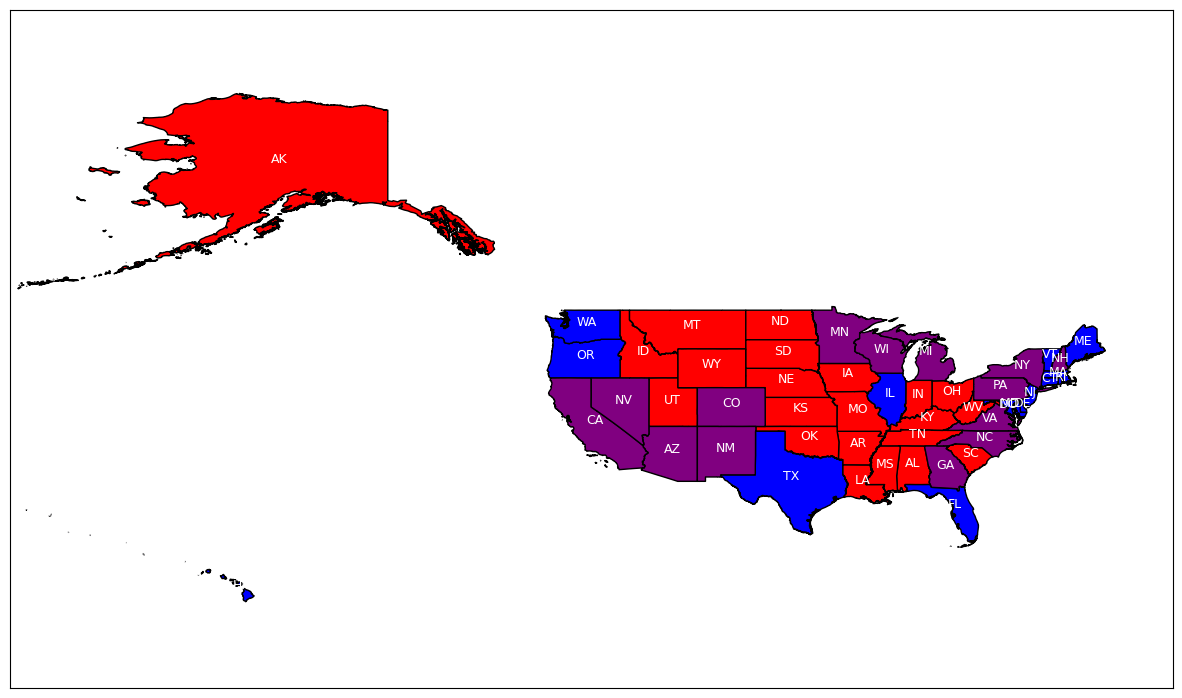

In [103]:

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Annotate state codes
for _, row in states_results_tmp.iterrows():
    centroid = row['geometry'].centroid
    x, y = centroid.x, centroid.y
    ax.annotate(
        text=row['state_code'],  # The text to display
        xy=(x, y),  # Coordinates of the centroid
        ha='center',  # Horizontal alignment
        fontsize=9,  # Font size
        color='white'  # Text color
    )

# Plot states based on winner
states_results_tmp[states_results_tmp['winner'] == 'trump'].plot(ax=ax, color='red', edgecolor='black')
states_results_tmp[states_results_tmp['winner'] == 'biden'].plot(ax=ax, color='blue', edgecolor='black')
states_results_tmp[states_results_tmp['winner'] == 'contentious'].plot(ax=ax, color='purple', edgecolor='black')

# Set plot options
plt.axis('square')
ax.set_xlim([-180, -60])
ax.set_ylim([10, 80])
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [104]:
states_results.to_csv('state_results_100_conti.csv', index=False, header=True)
fig.savefig('state_results_100_conti.png')

In [105]:
trump_vote = np.sum(states_results[states_results['winner'] == 'trump']['e_vote'])
biden_vote = np.sum(states_results[states_results['winner'] == 'biden']['e_vote'])
print(trump_vote, biden_vote)

150 169


In [106]:
import itertools

In [107]:
states_results = pd.read_csv('state_results_100_conti.csv')

In [108]:
num_vote_to_win = 270
trump_vote = np.sum(states_results[states_results['winner'] == 'trump']['e_vote'])
biden_vote = np.sum(states_results[states_results['winner'] == 'biden']['e_vote'])
print(trump_vote, biden_vote)

150 169


In [109]:
contentious_states = states_results.loc[states_results['winner'] == 'contentious',['state_code', 'e_vote']]
contentious_states

,state_code,e_vote
2,AZ,11
4,CA,55
5,CO,9
10,GA,16
22,MI,16
23,MN,10
28,NV,6
29,NH,4
31,NM,5
32,NY,29


In [110]:
def predict_winner(states, win_lose):
    trump_cont_vote = trump_vote + np.sum(states.iloc[np.where(np.array(win_lose) == 1)[0]]['e_vote'])
    biden_cont_vote = biden_vote + np.sum(states.iloc[np.where(np.array(win_lose) == 0)[0]]['e_vote'])
    

#     print(trump_cont_vote, biden_cont_vote)
    
    if trump_cont_vote >= num_vote_to_win:
        return 1
    elif biden_cont_vote >= num_vote_to_win:
        return 0
    else:
        return None

In [111]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

In [112]:
total = 0
n_bits = len(contentious_states)
n_possible_scenarios = 2**n_bits
draw = 0
for i in range(n_possible_scenarios):
    win_lose = list(map(int, get_bin(i, n_bits)))
    
    winner = predict_winner(contentious_states, win_lose)
    if winner != None:
        total += winner
    else:
        draw += 1

In [113]:
trump_chance_to_win = total/(n_possible_scenarios)
draw_chance = draw/n_possible_scenarios
biden_chance_to_win = 1 - draw_chance - trump_chance_to_win

In [114]:
print(trump_chance_to_win*100, biden_chance_to_win*100, draw_chance*100)

40.88134765625 58.10546875 1.01318359375


In [115]:
win_chance_dict = dict({'candidate': ['trump', 'biden', 'draw'],
                        'chance_to_win': [f'{trump_chance_to_win*100:.5f}',
                                          f'{biden_chance_to_win*100:.5f}',
                                          f'{draw_chance*100:.5f}']
                       })
win_chance_dict

{'candidate': ['trump', 'biden', 'draw'],
 'chance_to_win': ['40.88135', '58.10547', '1.01318']}

In [2]:
win_chance_df = pd.DataFrame(win_chance_dict)
win_chance_df.to_csv('win_chance_state_results_100_conti.csv', index=False, header=True)

NameError: name 'pd' is not defined